# Remote Sensor Data Processing and Orthorectification

## Part 1: Background

## Introduction

The launch and deployment of high-resolution, high-revisit rate satellite image sensors has allowed humans unprecedented perspectives of the entire Earth at sub-meter and finer resolutions. These satellite photographers, like WorldView 2 and WorldView 3, among others, orbit the Earth heliosynchronously and take massive amounts of image data every day. 

The signal collected at the satellite sensor during image capture, however, is really most useful if we can map that data to an exact area on Earth that we can reference using familiar coordinate systems, expressed in longitude, latitude, and height. The mapping from the sample points on the sensor plate (image space) to world coordinates (lat, long, z), however, is not trivial to calculate. For instance, line-scanning photo-sensors collect light across the sensor plane non-simultaneously over some (small) time interval, meaning that neighboring pixels might be sampled from different physical reference frames. It's also often the case that a sensor collects Earth imagery from a non-zero azimuthal angle to the world target, meaning that the sensor samples the Earth from an angle, instead of looking "straight down." Left uncorrected, projecting this data onto a linear plane (like a map) will produce images with non-uniform distance scales, meaning that the real physical distance (on the Earth) between two points on the image separated by, say, ten pixels, will be different from the real physical distance between another set of points on the image separated by ten pixels. The inherent complexity of the non-inertial reference frame of the satellite/sensor's Earth-orbit, the geometry of the Earth itself, and the physical operating specifications of the photo-sensor all contribute to a number of image-artifacts which must be taken into account, corrected, and normalized before any quantitative measurements or calculations can be reliably made. To calculate a correct mapping, it's necessary to understand the physical properties of the sensor at time-of-capture, including orientation angle, etc, as well as the sensor optical specs. This information is provided via sensor models.


## The Image to World Space Mapping 


### What is a Sensor Model?

A sensor model is a description of the physical parameters of the actual camera sensor along with data acquisition specifications. Sensor models provide the information needed to determine the relationship between sample locations on the sensor (pixels) and coordinates on the Earth. Sensor models can be extremely complicated; they're also often unavailable to the public, as they contain proprietary technical information owned by the sensor manufacturer. Therefore, manufacturers often provide good approximation to the model via a set of Rational Polynomial Coefficients (RPCs) as metadata along with the delivered images. This is often referred to as an RPC model. 


### Rational Polynomial Models

RPC models define a mapping from image coordinates (linescan number, pixel number) to world (lng, lat, height or X, Y, Z) coordinates as a ratio of two cubic polynomials in (X, Y, Z) for each pixel coordinate component. Each of the 20 elements in the cubic (X, Y, Z) polynomial are multiplied by a cooresponding coefficient. Hence, the RPC transform defining a given pixel coordinate uses a total of 80 polynomial coefficients. After normalizing the input coordinates by the sample scale (provided with the rpc metadata), determining pixel value from (X, Y, Z) is a matter of calculating and divding the polynomials.  


## Orthorectification

Orthorectification is the process of correctly projecting a raw sensor image to world coordinates. This can be accomplished with RPC models and Digital Elevation Maps (DEMs). The RPC model corrects artifacts that arise from lens distortion and sensor tilt, and accurate DEMs correct for topological relief.

### The effect of topological terrain and elevation

Orthorectification refers to the process of transforming an image to new coordinates for which the distance scale is uniform everywhere. The result of orthorectification is essentially a "projection" of an raw image to a virtual plane at a right angle to the sensor. An orthorecitfied image can be used to measure true physical distances. It's usually important to have an accurate DEM when orthorectifying; highly-topologic surfaces can distort distance scales. For instance, distance measurements on mountain sides will be inaccurate unless orthorectified with a DEM that accounts for significant local elevation differences.

### Digital Elevation Models (DEMs)

Digital Elevation Models are simply approximations to, or samples of, surface heights. They're created through various land-surveying techniques, including lidar, radar and GPS mapping. When used in orthorectification transforms, the higher the resolution and accuracy of a DEM, the "truer" the resultant ortho-photo will be. DEM's from the [SRTM](https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission) can be obtained using gbdxtools, and give about 30 meter resultion. 

## Part 2: Application: Warping and Orthorectification using gbdxtools

The gbdxtools package provides a "warp" method on all image classes, which can be used to orthorectify a raw image. Generally, the interface provides a means to apply _any_ transformation to the input image. 

In the following, we'll orthorectify uncorrected images and inspect the effects. In the process, we'll learn how to:
   * How to search for and instantiate raw, uncorrected imagery
   * Instantiate DEM's for an AOI
   * Orthorectify raw images using the warp interface
   
We'll also investigate the variance in the effect of orthonormalization at different places on Earth. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
from gbdxtools import IdahoImage, CatalogImage, DemImage
from shapely.geometry import shape, box
import numpy as np
import datetime as dt

### Image Search to Raw IdahoImage

We can use the image search UI tool to find some interesting terrain for transforming. Bogota, Columbia is one of the highest capitol cities in the world at an altitude of over 8,500 ft. The terrain is also mountainous and topological, making it an especially relevant test-case for undertanding the effects of orthonormalization. Below, we select an area of the city at the edge of the mountains. 

Fetching Image... 36 tiles


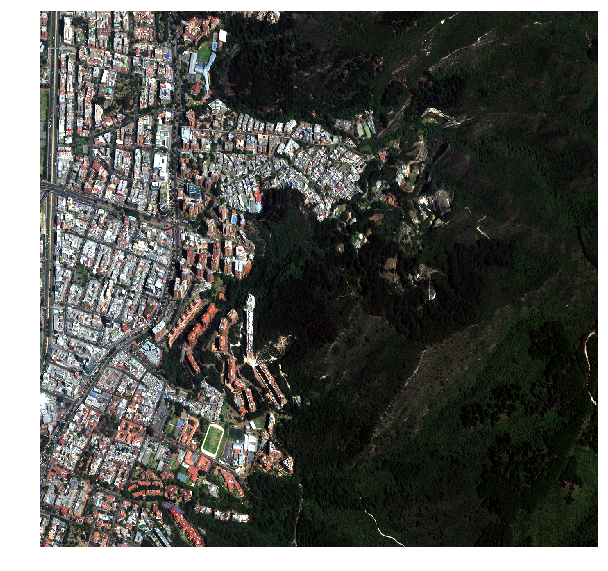

In [2]:
catalog_id = '10400100171BAD00'
bbox = '-74.033260345459, 4.6909765724368215, -74.0138626098633, 4.709624736237738'
g = box(*map(float, bbox.split(",")))
image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

When we insert the image, we instantiate a CatalogImage. We'll get the most recent IdahoId that covers our AOI from the CatalogImage parts. Then we can instantiate the corresponding raw IdahoImage by specifying product="1b" in the initialization arguments. 

In [3]:
import datetime as dt
to_datetime = lambda x: dt.datetime.strptime(x.ipe.metadata['image']['acquisitionDate'], "%Y-%m-%dT%H:%M:%S.%fZ")

parts = image.parts
sbox = box(*image.bounds)
try:
    idaho = sorted([p for p in parts if shape(p).contains(sbox)], key=to_datetime, reverse=True)[0]
except IndexError:
    print "None of the constiuent IdahoImage parts completely cover the AOI, try another location"

The variable "idaho" is an IdahoImage that has already been processed and orthorectified in IPE. We can use this image to compare to the results of our orthorectification.

Below, we instantiate the uncorrected image by passing in the idaho id, the product type "1b" and the relevant aoi.

Fetching Image... 30 tiles


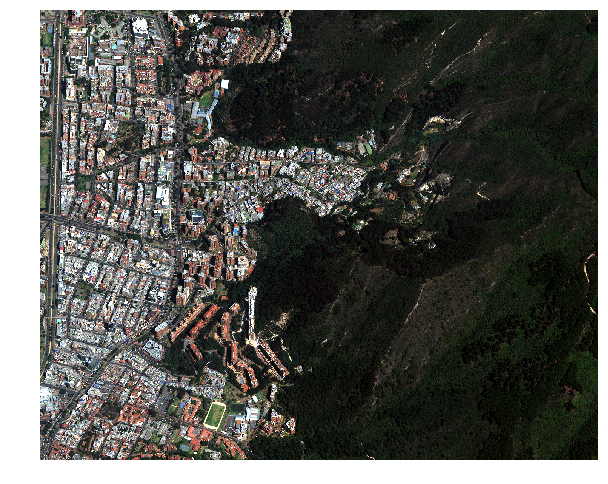

In [4]:
idaho_raw = IdahoImage(idaho.ipe.metadata['image']['imageId'], product='1b')
idaho_raw[g].plot(w=10, h=10)

This looks nothing like the AOI we selected in the UI or the corresponding IPE image. We expect that the orthorectification transform will be the correct mapping back to our AOI. 

### Instantiating a Relevant DEM

Although we can pass in _any_ value or set of coordinates to the warp function, we can expect that the accuracy of the orthorectification varies positively with the resolution of the DEM we pass in. We can readily get a DEM from the  SRTM project simply by instantiating a DemImage with out AOI. This provides a top-surface DEM at about 30 meter resolution. The DEM provides a two-dimensional sampling of height values on a grid over the AOI.

DEM's can be any 2-dimensional array-like object, and are interpolated before use in the coordinate transform calculation.

In [23]:
dem = DemImage(image.bounds)

### Implementing Orthorectification with a DEM

We'll pass in our DEM array to the warp function to accomplish orthorectification: 

Fetching Image... 36 tiles


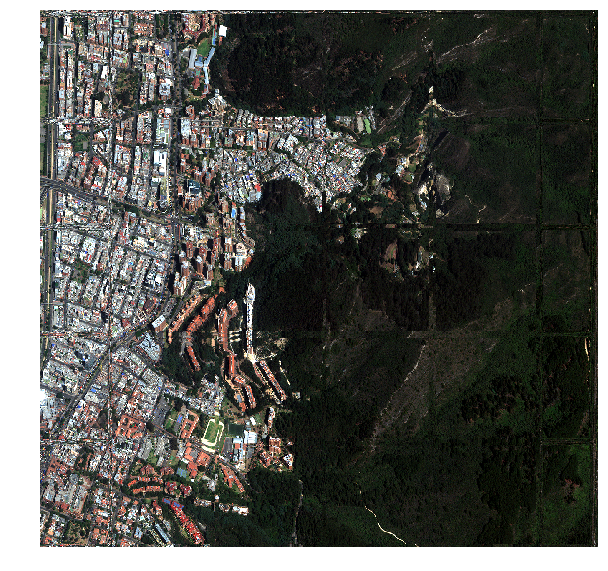

In [24]:
orthod = idaho_raw.warp(dem=dem)[g]
orthod.plot(w=10, h=10)

## We see that we have recovered our orginal AOI, which matches cloesly to IPE image above. 